In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
#!pip install mlxtend==0.19.0
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
#!pip install pygam
from pygam import GAM, s, te
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
#from google.colab import files

In [3]:
airquality=pd.read_csv("C:/Users/arab/Downloads/airquality.csv")
airquality=airquality[['Ozone','Solar.R','Wind','Temp']]
airquality=airquality.dropna()
airquality['TWcp']=airquality['Temp']*airquality['Wind']
airquality['TWrat']=airquality['Temp']/airquality['Wind']
airquality.head()

,Ozone,Solar.R,Wind,Temp,TWcp,TWrat
0,41.0,190.0,7.4,67,495.8,9.054054
1,36.0,118.0,8.0,72,576.0,9.000000
2,12.0,149.0,12.6,74,932.4,5.873016
3,18.0,313.0,11.5,62,713.0,5.391304
6,23.0,299.0,8.6,65,559.0,7.558140


In [4]:
X=airquality[['Solar.R','Temp', 'Wind','TWcp','TWrat']]
y=airquality[['Ozone']]
gam=GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X,y)

In [5]:
gam=GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X,y)
gam.gridsearch(X=X, y=y, lam=np.linspace(0, 10, 100), return_scores=True)
gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.7254
Link Function:                     IdentityLink Log Likelihood:                                  -689.8064
Number of Samples:                          111 AIC:                                             1429.0636
                                                AICc:                                            1443.9817
                                                GCV:                                              318.7047
                                                Scale:                                            199.0505
                                                Pseudo R-Squared:                                   0.8574
Feature Function                  Lam

C:\Users\arab\AppData\Local\Temp/ipykernel_2240/1364313868.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [6]:
random_state=2928893
airquality['CV'] = np.random.randint(low=0, high=10, size=(airquality.shape[0],))

LS_MSPE= []
Stepwize_MSPE= []
Ridge_MSPE = []
LASSO_MSPE = []
GAM_MSPE = []

for i in range(10):
  airquality_train = airquality.loc[airquality['CV'] != i]
  airquality_test = airquality.loc[airquality['CV'] == i]

  y_train = airquality_train['Ozone']
  X_train = airquality_train.drop(['Ozone','CV'],axis=1)
  y_test = airquality_test['Ozone']
  X_test = airquality_test.drop(['Ozone','CV'],axis=1)
  
  StdScaler = StandardScaler().fit(X_train)
  X_train_std = StdScaler.transform(X_train)
  X_test_std = StdScaler.transform(X_test)

  # LS
  LSModel = LinearRegression().fit(X_train, y_train)
  LS_MSPE.append(mean_squared_error(y_test, LSModel.predict(X_test)))

  # Stepwise
  MLReg = LinearRegression()
  sfs4 = sfs(MLReg, k_features=(1,5), floating=True, verbose=0, scoring='neg_mean_squared_error')
  sfs4.fit(X_train, y_train)
  X_train_sfs4 = sfs4.transform(X_train)
  X_test_sfs4 = sfs4.transform(X_test)
  MLReg.fit(X_train_sfs4, y_train)
  Stepwize_MSPE.append(mean_squared_error(y_test, MLReg.predict(X_test_sfs4)))

  # Ridge
  LMRidgeCV = RidgeCV(alphas=np.arange(0.5, 10, 0.01), cv=None, scoring='neg_mean_squared_error')
  LMRidgeCV.fit(X_train_std, y_train)
  LMRidge = Ridge(alpha = LMRidgeCV.alpha_)
  LMRidge.fit(X_train_std, y_train)
  Ridge_MSPE.append(mean_squared_error(y_test, LMRidge.predict(X_test_std)))

  # LASSO
  LMLassoCV = LassoCV(alphas = np.arange(0.5, 2, 0.01), cv = None)
  LMLassoCV.fit(X_train_std, y_train)
  LMLasso = Lasso()
  LMLasso.set_params(alpha=LMLassoCV.alpha_)
  LMLasso.fit(X_train_std, y_train)
  LASSO_MSPE.append(mean_squared_error(y_test, LMLasso.predict(X_test_std)))
    
  # GAM
  gam = GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X_train, y_train)
  gam.gridsearch(X=X_train, y=y_train, lam=np.linspace(3, 5, 20))
  GAM_MSPE.append(mean_squared_error(y_test, gam.predict(X_test)))

print(LS_MSPE)
print(Stepwize_MSPE)
print(Ridge_MSPE)
print(LASSO_MSPE)
print(GAM_MSPE)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[733.6053965351305, 198.0453232664674, 133.3528531264983, 175.32087325336133, 389.8708676560219, 124.68639245047795, 563.0612065426541, 686.5596239070004, 361.8862247081263, 387.96383702436657]
[764.7817751266084, 210.7707462137369, 122.02078876462494, 200.15642512658488, 422.34933764999903, 137.03113968967253, 640.1207267243669, 695.4977565962272, 347.8635694549749, 411.7642241234718]
[665.8533312612426, 222.3730053759804, 161.84720916954973, 171.34611098937893, 424.74441502710914, 135.19594931606673, 531.7881538377056, 625.470641478507, 446.461267413573, 437.87790907062754]
[681.4417428764972, 185.8096765562331, 145.75492287466204, 170.81340367731931, 482.12553804017705, 97.57883002916294, 563.2239574667782, 680.4468224250396, 449.3108513065354, 407.22707572062524]
[719.685504543122, 400.5666104125311, 68.72077802734262, 142.97627556918113, 141.2995013067864, 189.33839757982514, 546.7034399496769, 674.1178397516751, 141.56946014352016, 280.0986465458155]


   id Model        MSPE
0   0    LS  733.605397
1   1    LS  198.045323
2   2    LS  133.352853
3   3    LS  175.320873
4   4    LS  389.870868


<AxesSubplot:xlabel='Model', ylabel='MSPE'>

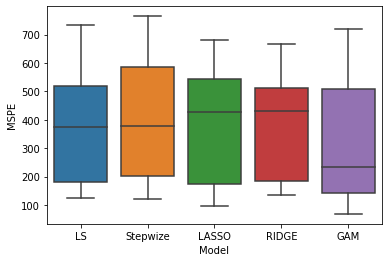

In [7]:
MSPEs=pd.DataFrame({'LS':LS_MSPE,
                    'Stepwize':Stepwize_MSPE,
                    'LASSO':LASSO_MSPE,
                    'RIDGE':Ridge_MSPE,
                    'GAM':GAM_MSPE})
MSPEs["id"] = MSPEs.index
MSPEs_long = pd.melt(MSPEs, id_vars='id',
                     var_name = 'Model',
                     value_name = 'MSPE',
                     value_vars=['LS','Stepwize','LASSO','RIDGE','GAM'])
print(MSPEs_long.head())
sns.boxplot(y="MSPE", x="Model", orient="v", data=MSPEs_long)

<AxesSubplot:xlabel='Model', ylabel='RMSPE'>

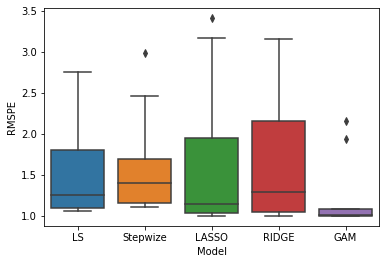

In [8]:
MSPEs = MSPEs.drop('id', axis=1)
RMSPEs = MSPEs.div(MSPEs.min(axis=1), axis=0)
RMSPEs["id"] = RMSPEs.index
RMSPEs_long = pd.melt(RMSPEs, id_vars='id',
                     var_name = 'Model',
                     value_name = 'RMSPE',
                     value_vars=['LS','Stepwize','LASSO','RIDGE','GAM'])
sns.boxplot(y="RMSPE", x="Model", orient="v", data=RMSPEs_long)

In [9]:
utils = importr('utils')
utils.install_packages('gam')

--- Please select a CRAN mirror for use in this session ---


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/gam_1.20.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 388470 bytes (379 KB)

R[write to console]: downloaded 379 KB




package 'gam' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\arab\AppData\Local\Temp\RtmpgpQGJs\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x000000001E390E40> [RTYPES.NILSXP]

In [10]:
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam

In [11]:
r_solar = robjects.FloatVector(airquality[["Solar.R"]].values)
r_wind = robjects.FloatVector(airquality[["Wind"]].values)
r_temp = robjects.FloatVector(airquality[["Temp"]].values)
r_twcp = robjects.FloatVector(airquality[["TWcp"]].values)
r_twrat = robjects.FloatVector(airquality[["TWrat"]].values)
r_ozone = robjects.FloatVector(airquality[["Ozone"]].values)

r_fmla = robjects.Formula("Ozone ~ s(Solar.R) + s(Wind) + s(Temp) + s(TWcp) + s(TWrat)")
r_fmla.environment['Ozone'] = r_ozone
r_fmla.environment['Solar.R'] = r_solar
r_fmla.environment['Wind'] = r_wind
r_fmla.environment['Temp'] = r_temp
r_fmla.environment['TWcp'] = r_twcp
r_fmla.environment['TWrat'] = r_twrat

ozone_gam = r_gam(r_fmla)
print(ozone_gam.names)

Exception ignored from cffi callback <function _consolewrite_ex at 0x000000001E332B80>:
Traceback (most recent call last):
  File "c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 3: invalid start byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x000000001E332B80>:
Traceback (most recent call last):
  File "c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\arab\appdata\loca

 [1]
 [4]
 [7]
[10]
[13]
[16]
[19]
[22]
[25]
[28]
[31]
[34]
[37]



In [12]:
ozone_gam = r_gam(r_fmla)
print(ozone_gam.names)

Exception ignored from cffi callback <function _consolewrite_ex at 0x000000001E332B80>:
Traceback (most recent call last):
  File "c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 3: invalid start byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x000000001E332B80>:
Traceback (most recent call last):
  File "c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\arab\appdata\loca

 [1]
 [4]
 [7]
[10]
[13]
[16]
[19]
[22]
[25]
[28]
[31]
[34]
[37]



c:\users\arab\appdata\local\programs\python\python38\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


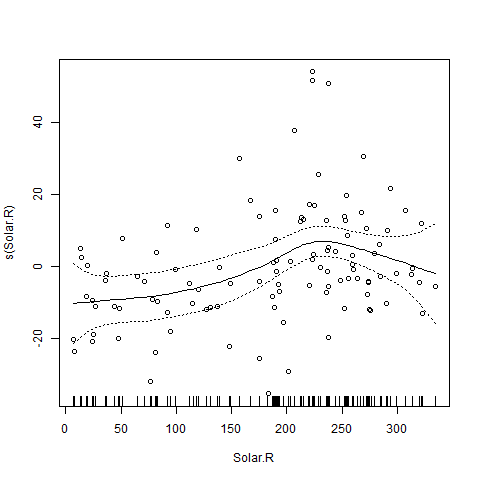

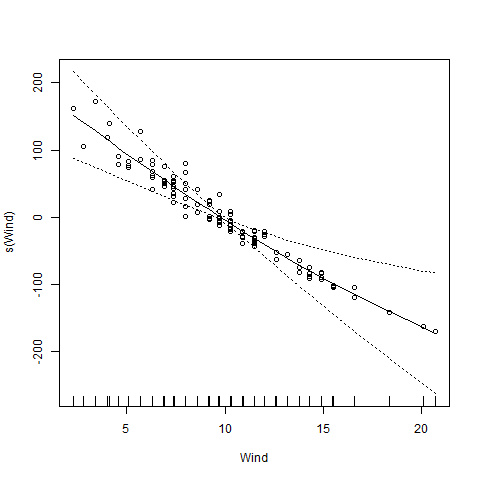

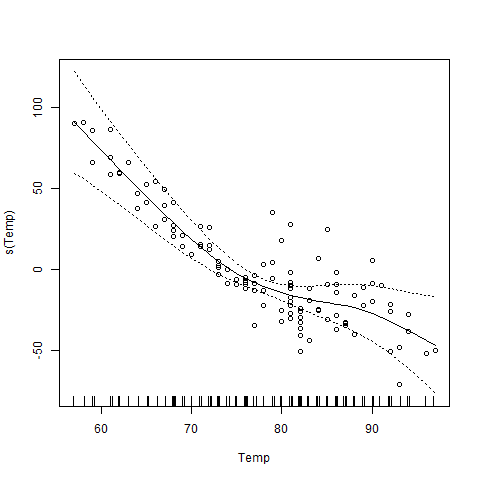

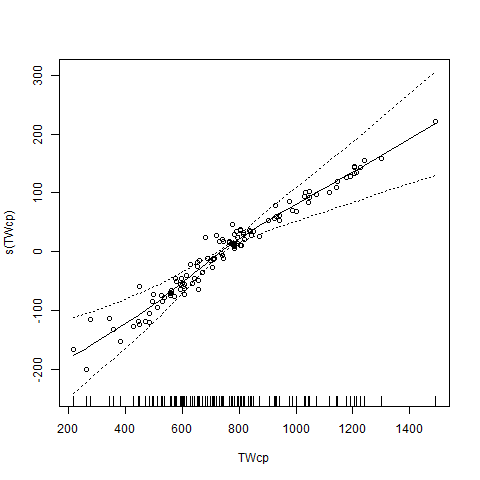

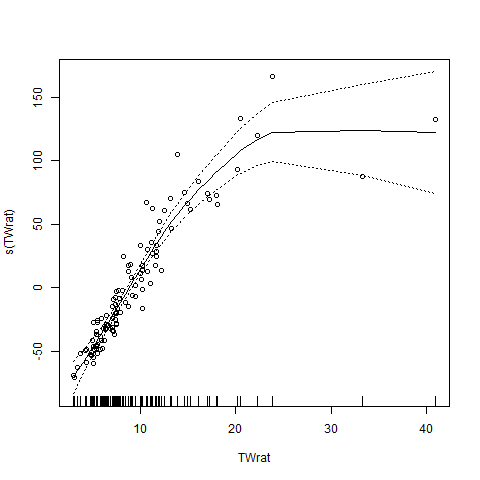

In [13]:
%load_ext rpy2.ipython
%R -i ozone_gam plot(ozone_gam, residuals=TRUE,se=TRUE, scale=20);